In [476]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [477]:
T = 0.1
s = ctl.TransferFunction.s

In [478]:
G = 1/(s**2 + 2*s)
C = (21.9543820023537*s + 64.585390060199)/(1.0*s + 5.35662298681269)

G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([21.954382  , 64.58539006]), array([ 1.        ,  7.35662299, 32.66762798, 64.58539006]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [479]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([0.00468269, 0.00438077]), array([ 1.        , -1.81873075,  0.81873075]), 0.1)

In [480]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([ 19.86356899, -14.76940562]), array([ 1.        , -0.57749713]), 0.1)

In [481]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 0.0930149 ,  0.01785729, -0.06470143]), array([ 1.        , -2.30321298,  1.88689983, -0.53751609]), 0.1)

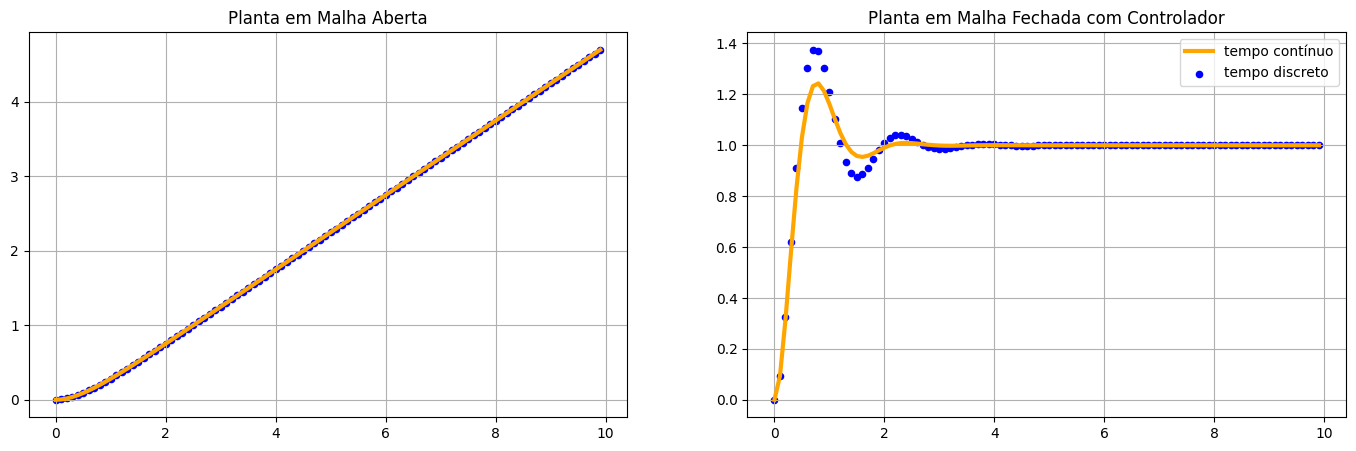

In [482]:
tData = np.arange(0, 10, T)
plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
time, continuous = ctl.step_response(G, T=tData)
time, digital    = ctl.step_response(G_z, T=tData)
plt.scatter(time, continuous, color='blue', s=20, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

plt.subplot(1, 2, 2)
time, continuous = ctl.step_response(G_feedback, T=tData)
time, digital    = ctl.step_response(G_z_feedback, T=tData)
plt.plot(time, continuous, color='orange', linewidth=3, label='tempo contínuo')
plt.scatter(time, digital, color='blue', s=20, label='tempo discreto')
plt.title('Planta em Malha Fechada com Controlador')
plt.legend()
plt.grid()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **getOutputString**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **resetSystem**: reinicia as variáveis globais do sistema
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

In [483]:
def getDigitalFraction(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    return list(num), list(den)


num, den = getDigitalFraction(G_z)
num, den

([0.004682688269495472, 0.004380774076605309],
 [1.0, -1.8187307530779817, 0.8187307530779818])

In [484]:
def getModelString(G_z):
    num, den = getDigitalFraction(G_z)
    out = ''
    
    for i in range(0, len(num)): 
        out += f'Xn[{i}]*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Yn[{i}]*({-1*den[i]:.6f}) + '
    
    out = out.replace('X_n0', 'X_n')[:-3]
    xSize = len(num)
    ySize = len(den)
    return out, xSize, ySize 


output, xSize, ySize = getModelString(G_z)
print(output + ';')

Xn[0]*(0.004683) + Xn[1]*(0.004381) + Yn[1]*(1.818731) + Yn[2]*(-0.818731);


In [485]:
Xn = np.zeros(xSize)
Yn = np.zeros(ySize)

def compute(input):
    global Xn, Yn, xSize, ySize
    
    for n in range(xSize-1, 0, -1):
        Xn[n] = Xn[n-1]

    for n in range(ySize-1, 0, -1):
        Yn[n] = Yn[n-1]
    
    Xn[0] = input
    Yn[0] = eval(output)
    return Yn[0]

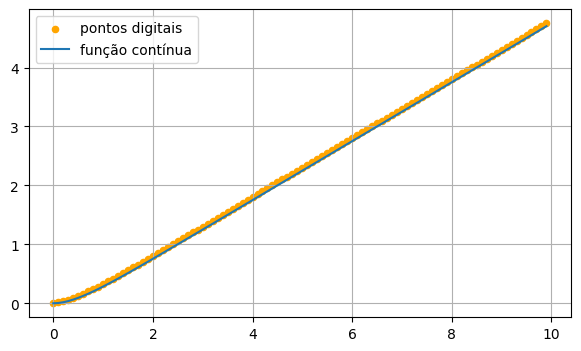

In [486]:
step = 1
time = np.arange(0, 10, T)
digital = [compute(step) for t in time]
time, continuous = ctl.step_response(G, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# DIGITALIZANDO O CONTROLADOR
- Comparando os dados contínuo e digital de forma gráfica através de um step

In [487]:
output, xSize, ySize = getModelString(C_z)
print(output + ';')
xSize, ySize

Xn[0]*(19.863569) + Xn[1]*(-14.769406) + Yn[1]*(0.577497);


(2, 2)

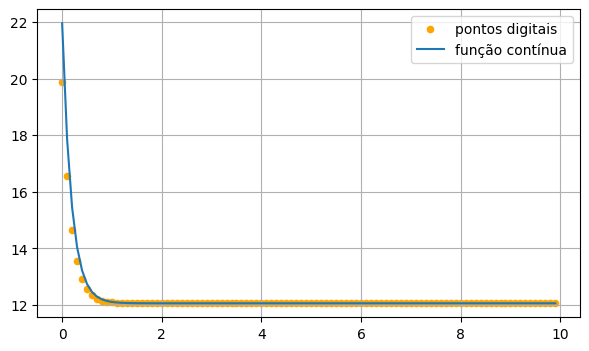

In [488]:
Xn = np.zeros(xSize)
Yn = np.zeros(ySize)

def control(input, setpoint):
    global Xn, Yn, xSize, ySize
    
    for n in range(xSize-1, 0, -1):
        Xn[n] = Xn[n-1]

    for n in range(ySize-1, 0, -1):
        Yn[n] = Yn[n-1]
    
    Xn[0] = setpoint - input
    Yn[0] = eval(output)
    return Yn[0]


time = np.arange(0, 10, T)
digital = [control(input=1, setpoint=2) for t in time]
time, continuous = ctl.step_response(C, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# SIMULANDO SISTEMA
- O controlador envia um sinal $out$ para a planta, que gera um outro sinal, que é comparado com o setpoint e enviado de novo ao controlador

In [489]:
gout, gxSize, gySize = getModelString(G_z)
cout, cxSize, cySize = getModelString(C_z)

gout = gout.replace('X', 'GX').replace('Y', 'GY')
cout = cout.replace('X', 'CX').replace('Y', 'CY')

print(gout)
print(cout)

GXn[0]*(0.004683) + GXn[1]*(0.004381) + GYn[1]*(1.818731) + GYn[2]*(-0.818731)
CXn[0]*(19.863569) + CXn[1]*(-14.769406) + CYn[1]*(0.577497)


In [490]:
GXn = np.zeros(gxSize)
GYn = np.zeros(gySize)
CXn = np.zeros(cxSize)
CYn = np.zeros(cySize)
bounds = (-100, 200)


def compute(input):
    global GXn, GYn, gxSize, gySize
    
    for n in range(gxSize-1, 0, -1):
        GXn[n] = GXn[n-1]

    for n in range(gySize-1, 0, -1):
        GYn[n] = GYn[n-1]
    
    GXn[0] = input
    GYn[0] = eval(gout)
    return GYn[0]


def control(input, setpoint):
    global CXn, CYn, cxSize, cySize
    global bounds
    
    for n in range(cxSize-1, 0, -1):
        CXn[n] = CXn[n-1]

    for n in range(cySize-1, 0, -1):
        CYn[n] = CYn[n-1]
    
    CXn[0] = setpoint - input
    CYn[0] = eval(cout)

    if CYn[0] > bounds[1]: CYn[0] = bounds[1]
    if CYn[0] < bounds[0]: CYn[0] = bounds[0]
    return CYn[0]

In [491]:
setpoint = 10
output   = 0
tData = []
yData = []
xData = []

for time in np.arange(0, 10, T):
    input  = compute(output)
    output = control(input, setpoint)

    tData.append(time)
    xData.append(input)
    yData.append(output)


time = np.linspace(0, tData[-1], 1000)
time, desired = ctl.step_response(setpoint*G_feedback, T=time)
np.array(yData[:10])

array([198.63569   , 147.17583595,  85.09245084,  25.05000527,
       -23.7557123 , -56.24232362, -71.24819246, -70.74485392,
       -58.73317514, -40.0834896 ])

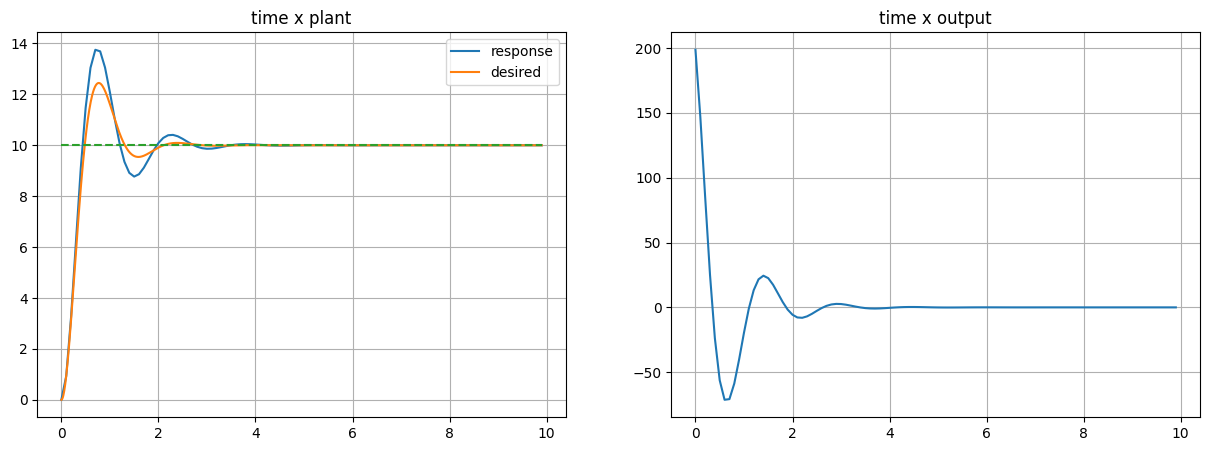

In [492]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(tData, xData, label='response')
plt.plot(time, desired, label='desired')
plt.plot(tData, [setpoint for i in tData], '--')
plt.title('time x plant')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(tData, yData)
plt.title('time x output')
plt.grid()